# 🏋️‍♂️ Fine-Tuning TimeSformer for Workout Classification with Focal Loss 

#### TimeSformer stands for Time-Space Transformer.
#### It's a Transformer-based model for video classification, adapted from the Vision Transformer (ViT).
#### This specific checkpoint is pretrained and fine-tuned on the Something-Something V2 dataset (SSv2), which is a fine-grained action recognition dataset with ~220k short videos and 174 action classes.


In [1]:
import torch
print(torch.cuda.is_available())

C:\Users\moralon\anaconda3\envs\VideoClass\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True


In [2]:
#Install Dependencies
!pip install git+https://github.com/facebookresearch/pytorchvideo


# Core libraries
import os
import sys
import gc
import time
import datetime

# PyTorch and optimization
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Transformers
import transformers
# Check PyTorchVideo version
print("transformers version:", transformers.__version__)
from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification

# PyTorchVideo
import pytorchvideo
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    Normalize,
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    RandomShortSideScale
)

# TorchVision
from torchvision.io import read_video
from torchvision.transforms import (
    Compose,
    Lambda,
    RandomCrop,
    RandomHorizontalFlip,
    Resize,
)
from torchvision.transforms._transforms_video import CenterCropVideo
from torchvision.transforms.functional import to_pil_image

# Data science tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Utilities
from tqdm import tqdm

# Check PyTorchVideo version
print("PyTorchVideo version:", pytorchvideo.__version__)



  Cloning https://github.com/facebookresearch/pytorchvideo to c:\users\moralon\appdata\local\temp\pip-req-build-uvq2ghya
  Resolved https://github.com/facebookresearch/pytorchvideo to commit 6cdc929315aab1b5674b6dcf73b16ec99147735f
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/pytorchvideo 'C:\Users\moralon\AppData\Local\Temp\pip-req-build-uvq2ghya'


transformers version: 4.40.2


C:\Users\moralon\anaconda3\envs\VideoClass\lib\site-packages\torchvision\transforms\_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
C:\Users\moralon\anaconda3\envs\VideoClass\lib\site-packages\torchvision\transforms\_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


PyTorchVideo version: 0.1.5


## 📊 Dataset Overview & Class Distribution
#### Defines a function to count the number of videos per class and visualize class imbalance. 

Dataset information:
Classes are ['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raise', 'leg extension', 'leg raises', 'plank', 'pull Up', 'push-up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep Pushdown']
The number of classes is 22

Plotting class distrubtion


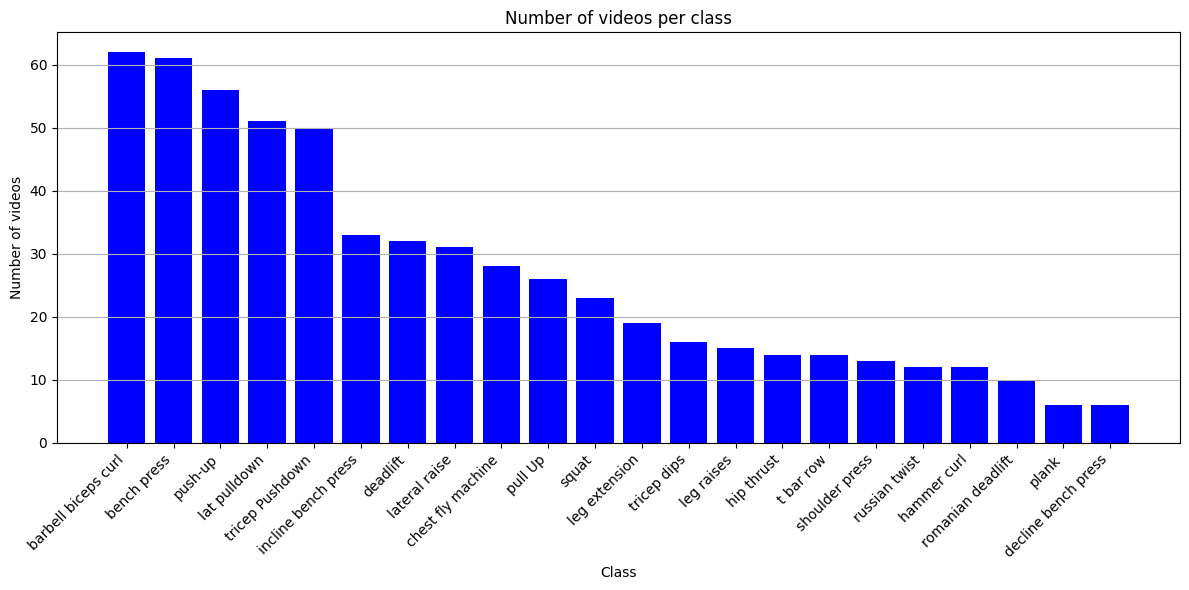

In [3]:
dataset_dir = r'workout-dataset'
class_folders = [folder for folder in os.listdir(dataset_dir) if
                 os.path.isdir(os.path.join(dataset_dir, folder))]
num_of_classes = len(class_folders)

print('Dataset information:')
print(f"Classes are {class_folders}")
print(f"The number of classes is {num_of_classes}")
def plot_class_distribution(df):
    #df["Percentage"] = 100 * df["Num Videos"] / df["Num Videos"].sum()
    # Bar chart
    plt.figure(figsize=(12, 6))
    plt.bar(df["Class"], df["Number of videos"], color='blue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Class")
    plt.ylabel("Number of videos")
    plt.title("Number of videos per class")
    plt.grid(axis="y")
    plt.tight_layout()
    plt.show()


def class_distribution(dataset_dir):
    class_counts = {}
    for class_name in class_folders:
        class_path = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_path):
            video_files = [file for file in os.listdir(class_path) if file[-4:] == '.mp4']
            class_counts[class_name] = len(video_files)

    df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Number of videos"])
    df = df.sort_values("Number of videos", ascending=False).reset_index(drop=True)
    dataset_len = df["Number of videos"].sum()

    plot_class_distribution(df)

    return dataset_len,df


print('\nPlotting class distrubtion')
dataset_len,df_dist = class_distribution(dataset_dir)

## 🏷️ Label Encoding

#### Creates mappings between class names and numerical labels to use during training.

In [4]:
label2id = {class_folders[idx]:idx for idx in range(len(class_folders))}
id2label = {v: k for k, v in label2id.items()}

# 🧠 Model & Processor Initialization
#### This section loads the TimeSformer model (facebook/timesformer-base-finetuned-ssv2) and its image processor. The model was pretrained on the Something-Something V2 (SSv2) dataset, which contains short video clips focused on human-object interactions and fine-grained motion understanding. This makes it particularly well-suited for the exercise type classification task, where recognizing subtle temporal patterns and body movements is essential. Utilizing a pretrained model also helps improve performance, especially given that the dataset is relatively small and probably not suitable for training a model from scratch.

In [5]:
#from transformers import VideoMAEImageProcessor, VideoMAEForVideoClassification
from transformers import AutoImageProcessor, TimesformerForVideoClassification
label2id = {class_folders[idx]:idx for idx in range(len(class_folders))}
id2label = {v: k for k, v in label2id.items()}


model_ckpt = "facebook/timesformer-base-finetuned-ssv2"
image_processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = TimesformerForVideoClassification.from_pretrained(
    model_ckpt,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # True when you have a different numnber of classes then the original pre-trained model
)
device = "cuda" if torch.cuda.is_available() else "cpu"

#model_ckpt = "MCG-NJU/videomae-base"
#image_processor = VideoMAEImageProcessor.from_pretrained(model_ckpt)
#model = VideoMAEForVideoClassification.from_pretrained(
 #   model_ckpt,
  #  label2id=label2id,
   # id2label=id2label,
    #ignore_mismatched_sizes=False,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
#).to(device)



preprocessor_config.json:   0%|          | 0.00/412 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/486M [00:00<?, ?B/s]

Some weights of TimesformerForVideoClassification were not initialized from the model checkpoint at facebook/timesformer-base-finetuned-ssv2 and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([174, 768]) in the checkpoint and torch.Size([22, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([174]) in the checkpoint and torch.Size([22]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 📐 Dataset Parameter Setup
#### Normalization parameters (mean and std), image size and more are extracted from the pretrained image processor to ensure inputs are preprocessed consistently with the original training setup. 

In [6]:
# Assuming image_processor and model are already loaded
dataset_params = {'side_size':256}
dataset_params['mean'] = image_processor.image_mean
dataset_params['std'] = image_processor.image_std
print(f"Normalization mean: {dataset_params['mean']}")
print(f"Normalization std: {dataset_params['std']}")

if "shortest_edge" in image_processor.size:
    height = width = image_processor.size["shortest_edge"]
else:
    height = image_processor.size["height"]
    width = image_processor.size["width"]
dataset_params['crop_size'] = (height, width)
print(f"Resize target (height, width): {dataset_params['crop_size'] }")

dataset_params['num_of_frames'] = model.config.num_frames
sample_rate = 4
fps = 30
dataset_params["max_clip_duration"] = dataset_params['num_of_frames'] * sample_rate / fps #1
#dataset_params["max_clip_duration"] = 2
print(f"Number of frames to sample: {dataset_params['num_of_frames']}")

Normalization mean: [0.45, 0.45, 0.45]
Normalization std: [0.225, 0.225, 0.225]
Resize target (height, width): (224, 224)
Number of frames to sample: 8


## 📁 Creating the Dataset DataFrame

#### Constructs a structured DataFrame containing all video paths and corresponding classes and encoded labels, to used later for the video dataset for easy indexing.

In [7]:
def create_data_df(dataset_dir, class_folders,label_encoding):
    data = {'Video path': [],'Label str': [],
            'Video duration':[]
            }

    label_strings = []

    for folder in class_folders:
        class_path = os.path.join(dataset_dir, folder)
        for file in os.listdir(class_path):
            if file.split('.')[-1] == 'mp4':
                video_path = os.path.join(class_path, file)
                data['Video path'].append(video_path)
                data['Label str'].append(folder)
                label_strings.append(folder)

                #Get video duration to see how it is distubited in the dataset
                video = EncodedVideo.from_path(video_path)
                video_duration = int(video.duration)
                data['Video duration'].append(video_duration)


    df = pd.DataFrame(data)
    df['Label'] = df['Label str'].map(label_encoding)

    return df

# Divide to train and val - stratify ensures all classes are proportionally represented in both subsets.
# A relativly small porporation of the val dataset as some classes are small and we want to have

def split_train_val(df):
    train_df,val_df = train_test_split(
      df,
      test_size=0.2,
      stratify=df['Label'],
      random_state=42)

    return train_df.reset_index(drop=True),val_df.reset_index(drop=True)

## Create DataFrame and Split
df_data = create_data_df(dataset_dir,class_folders,label2id)
df_train,df_val = split_train_val(df_data)

print(f"Number of videos on train {len(df_train)}")
print(f"Number of videos on val {len(df_val)}")

model.safetensors:   0%|          | 0.00/486M [00:00<?, ?B/s]

Number of videos on train 472
Number of videos on val 118


# 📊 Video Duration Distribution
#### To ensure consistent input lengths and reduce computational load, I examined the distribution of video durations across the dataset. The histogram below reveals that most videos are relatively short, but a few extend significantly longer. The maximum duration is 228 seconds, which translates to 6,840 frames at 30 fps — a size that is memory-intensive and had caused performance issues during processing.
#### A maximum clip duration during loading of 1 seconds will be applied.

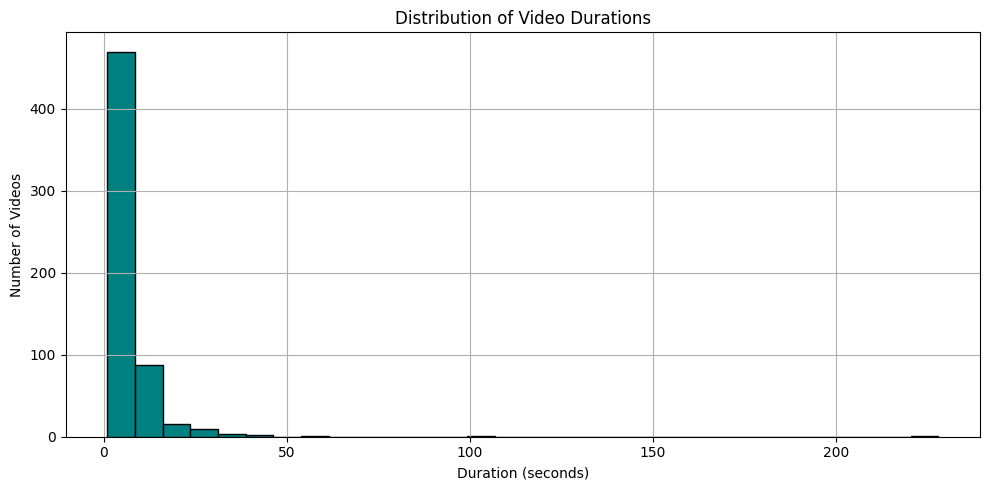

Max video duration: 228
Min video duration: 1
Mean video duration: 6.559322033898305


In [8]:
def plot_duration_distribution(df):
    plt.figure(figsize=(10, 5))
    plt.hist(df['Video duration'], bins=30, color='teal', edgecolor='black')
    plt.title("Distribution of Video Durations")
    plt.xlabel("Duration (seconds)")
    plt.ylabel("Number of Videos")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_duration_distribution(df_data)
print(f"Max video duration: {df_data['Video duration'].max()}")
print(f"Min video duration: {df_data['Video duration'].min()}")
print(f"Mean video duration: {df_data['Video duration'].mean()}")

# 🎥 Custom Dataset & Pathway Preparation
#### This section defines how videos are loaded, preprocessed, and fed into the model:

#### Dual-pathway setup:
##### The PackPathway module prepares video frames for models that benefit from both fast (dense) and slow (sparse) temporal representations, improving motion and context understanding.

#### Custom PyTorch Dataset:
##### ExerciseDataset is a custom dataset that handles video loading and labeling, applies a sequence of transformations, and limits the clip duration to reduce memory usage.

#### Train/Validation DataLoaders:
##### Separate data pipelines are built for training and validation, with appropriate shuffling and augmentations, ensuring efficient and structured model input.

In [9]:
class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors.
    """
    def __init__(self):
        super().__init__()

    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // 4
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

class ExerciseDataset(Dataset):

    def __init__(self, df_data,dataset_dir,class_folders,dataset_len,dataset_params,data_type):

        """
        Custom dataset for exercises

        """
        self.df_data = df_data
        self.video_paths = self.df_data['Video path']
        self.encoded_labels = self.df_data['Label']
        self.dataset_dir = dataset_dir
        self.class_folders = class_folders
        self.data_type = data_type #Train or val
        #self.class_paths = [os.path.join[self.dataset_dir,folder] for folder in self.class_folders if os.isdir(folder)]
        self.dataset_len = dataset_len
        self.dataset_params = dataset_params

        #image trasnform
        if self.data_type == 'train':
          self.transform = ApplyTransformToKey(
                  key="video",
                  transform=Compose(
                  [UniformTemporalSubsample(self.dataset_params['num_of_frames']),
                      Lambda(lambda x: x/255.0),
                      Normalize(self.dataset_params['mean'], self.dataset_params['std']),
                      RandomShortSideScale(min_size=self.dataset_params['side_size'],max_size=self.dataset_params['side_size']),
                      CenterCropVideo(self.dataset_params['crop_size']),
                      #PackPathway()
                      ]))
        elif self.data_type == 'val':
          self.transform = ApplyTransformToKey(
                  key="video",
                  transform=Compose(
                  [UniformTemporalSubsample(self.dataset_params['num_of_frames']),
                      Lambda(lambda x: x/255.0),
                      Normalize(self.dataset_params['mean'], self.dataset_params['std']),
                      Resize(self.dataset_params['crop_size']),
                      #PackPathway()
                      ]))


    def __len__(self):
         return len(self.video_paths)

    def __getitem__(self, idx):
        path = self.video_paths[idx]
        label = torch.tensor(self.encoded_labels[idx], dtype=torch.long)

        video = EncodedVideo.from_path(path,decode_audio=False)
        clip_duration = int(video.duration)
        video_data = video.get_clip(start_sec=0.0, end_sec=min(dataset_params['max_clip_duration'],clip_duration))
        video_data = self.transform(video_data)
        video_tensor = video_data["video"]  # (C, T, H, W)

        return {
            "video": video_tensor,
            "label": label
        }

train_dataset = ExerciseDataset(df_train,dataset_dir,class_folders,dataset_len,dataset_params,'train')
val_dataset = ExerciseDataset(df_val,dataset_dir,class_folders,dataset_len,dataset_params,'val')

model_params = {'batch_size':2,
             'learning_rate':5e-5,
             'num_of_epochs':6,
             'num_of_workers':0}






## 🎞️ Visualizing Sample Video Frames

#### GIF Preview of Training Example
##### To better understand what the model sees, we randomly sample a training video, reverse the normalization process, and visualize the clip as a GIF.

##### This helps confirm:
##### - The video tensor is correctly shaped and preprocessed.
##### - The temporal sequence and visual content are preserved.
##### - The transformations applied (e.g., resizing, cropping) are appropriate for model input.

##### This step provides a valuable sanity check before model training begins.


Showing a random video from our train dataset, idx 375


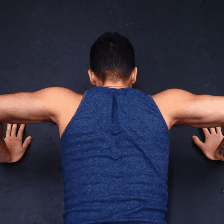

In [10]:
import imageio
import numpy as np
from IPython.display import Image
import random


def unnormalize_img(img,dataset_params):
    """Un-normalizes the image pixels."""
    img = (img * dataset_params['std']) + dataset_params['mean']
    img = (img * 255).astype("uint8")
    return img.clip(0, 255)

def create_gif(video_tensor, dataset_params, filename="sample.gif"):
    """Prepares a GIF from a video tensor.
...
    The video tensor is expected to have the following shape:
    (num_frames, num_channels, height, width).
    """
    frames = []
    for video_frame in video_tensor:
        frame_unnormalized = unnormalize_img(video_frame.permute(1, 2, 0).numpy(),dataset_params)
        frames.append(frame_unnormalized)
    kargs = {"duration": 0.25}
    imageio.mimsave(filename, frames, "GIF", **kargs)
    return filename

def display_gif(video_tensor, gif_name="sample1.gif"):
    """Prepares and displays a GIF from a video tensor."""
    video_tensor = video_tensor.permute(1, 0, 2, 3)
    gif_filename = create_gif(video_tensor, dataset_params,gif_name)
    return Image(filename=gif_filename)

idx = np.random.randint(0, len(train_dataset))
print(f"Showing a random video from our train dataset, idx {idx}")
sample_video = train_dataset[idx]
video_tensor = sample_video["video"]
display_gif(video_tensor)

In [11]:
del sample_video,video_tensor

# 🧩 CustomLossTrainer Class
#### Defines CustomLossTrainer, a subclass of Hugging Face’s Trainer that overrides compute_loss to support a custom loss function (e.g., Focal Loss). This is essential for handling class imbalance in multi-class classification tasks.
#### Focal loss is designed to address class imbalance by Focusing learning on hard, misclassified examples.



In [12]:
from transformers import Trainer,TrainingArguments
import torch.nn.functional as F

class CustomLossTrainer(Trainer):
    def __init__(self, *args, loss_fn=None, **kwargs):
        super().__init__(*args, **kwargs)
        # Store your custom loss function.
        # This should take (logits, labels) as arguments.
        self.loss_fn = loss_fn


    def compute_loss(self, model, inputs, return_outputs=False,**kwargs):
        # Assume your inputs include "labels" and your model returns logits.
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Compute the custom loss using your loss function.
        loss = self.loss_fn(logits, labels)
        
        return (loss, outputs) if return_outputs else loss



def focal_loss(logits, labels, gamma=2.0, alpha=0.25):
    # Calculate standard cross-entropy loss first.
    ce_loss = F.cross_entropy(logits, labels, reduction='none')
    
    # Get softmax probabilities.
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss.
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    return focal_loss.mean()

# 📦 TrainingArguments Setup
#### This section defines the TrainingArguments used by Hugging Face's Trainer. It configures key training parameters such as learning rate, batch size, number of epochs, and evaluation strategy. The model is set to save and reload the best-performing checkpoint based on accuracy, and the output directory is dynamically named to reflect the learning rate and batch size

In [13]:

model_name = model_ckpt.split("/")[-1]
new_model_name = f"{model_name}-finetuned-exercise-lr{model_params['learning_rate']}-batchsize{model_params['batch_size']}-WithFocalLoss"
num_epochs = 6

args = TrainingArguments(
    new_model_name,
    remove_unused_columns=False,
    eval_strategy="epoch",
    logging_strategy="epoch", 
    save_strategy="epoch",
    num_train_epochs=num_epochs, 
    learning_rate=model_params['learning_rate'],
    fp16=True,
    per_device_train_batch_size=model_params['batch_size'],
    per_device_eval_batch_size=model_params['batch_size'],
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    report_to=[],
    metric_for_best_model="accuracy",
    push_to_hub=False
)

# 🧮 compute_metrics Function
#### This section defines the compute_metrics function using Hugging Face's evaluate library. It calculates accuracy and weighted F1-score on validation predictions, enabling fair performance assessment under class imbalance during training and evaluation.
#### Focal loss - Designed to address class imbalance by Focusing learning on hard, misclassified examples. gamma: focusing parameter (default = 2); higher → more focus on hard examples. alpha: class-balancing factor (default = 0.25); used to reduce bias toward frequent classes

### F1 Measures how well the model balances precision and recall


In [14]:
!pip install evaluate
import evaluate

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    references = eval_pred.label_ids

    return {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=references)["accuracy"],
        "f1": f1_metric.compute(predictions=predictions, references=references, average="weighted")["f1"]
    }

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.5.1
    Uninstalling fsspec-2025.5.1:
      Successfully uninstalled fsspec-2025.5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidi

In [15]:
def collate_fn(examples):
    # permute to (T, C, H, W)
    pixel_values = torch.stack(
        [example["video"].permute(1, 0, 2, 3) for example in examples]
    )
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


In [16]:
import psutil
import torch

# RAM
print(f"RAM used: {psutil.virtual_memory().used / 1024 ** 3:.2f} GB")

# GPU (if using CUDA)
if torch.cuda.is_available():
    print(f"GPU memory used: {torch.cuda.memory_allocated() / 1024 ** 3:.2f} GB")
torch.cuda.empty_cache()

RAM used: 2.10 GB
GPU memory used: 0.00 GB


# 🧠 CustomLossTrainer Instantiation

In [17]:
trainer = CustomLossTrainer(
    model,
    args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
    loss_fn=focal_loss,  # Pass your custom loss function here.
)

# Check device
print(next(trainer.model.parameters()).device)  # Should show: cuda:0

cuda:0


## 🏋️‍♂️ Train

In [18]:
train_results = trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.416600,0.195325,0.737288,0.707764
2,0.030600,0.116786,0.762712,0.755031
3,0.002400,0.074050,0.881356,0.874425
4,0.000200,0.094876,0.864407,0.867651
5,0.000000,0.096861,0.864407,0.868798
6,0.000000,0.096405,0.872881,0.875314


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

#### Save the best model based on val accuracy 

In [22]:
best_model_path = trainer.state.best_model_checkpoint
print("Best checkpoint:", best_model_path)

from transformers import PreTrainedModel
import shutil
import os

# Get the best checkpoint path
best_model_path = trainer.state.best_model_checkpoint
print(f"Best model checkpoint found at: {best_model_path}")

# Define your custom save directory
target_dir = os.path.join(new_model_name,"best_model")

# Save the best model
trainer.model.save_pretrained(target_dir)
image_processor.save_pretrained(target_dir)

print(f"Best model and processor saved to: {target_dir}")
!zip -r best_model.zip best_model

Best checkpoint: timesformer-base-finetuned-ssv2-finetuned-exercise-lr5e-05-batchsize2-WithFocalLoss/checkpoint-354
Best model checkpoint found at: timesformer-base-finetuned-ssv2-finetuned-exercise-lr5e-05-batchsize2-WithFocalLoss/checkpoint-354
Best model and processor saved to: timesformer-base-finetuned-ssv2-finetuned-exercise-lr5e-05-batchsize2-WithFocalLoss/best_model
	zip warning: name not matched: best_model

zip error: Nothing to do! (try: zip -r best_model.zip . -i best_model)


## 📊 Validation Accuracy and F1 Score per Epoch
#### Validation accuracy and F1 score are extracted from the trainer’s log history and plotted across epochs.

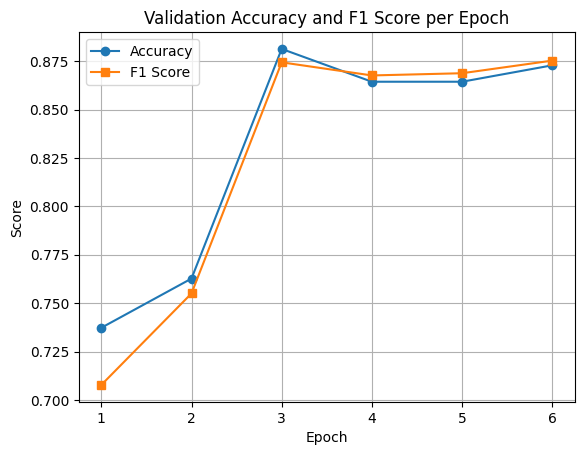

In [21]:
# Extract accuracy and epoch info
accuracy = []
f1_score = []
epochs = []

for log in trainer.state.log_history:
    if 'eval_accuracy' in log and 'eval_f1' in log:
        accuracy.append(log['eval_accuracy'])
        f1_score.append(log['eval_f1'])
        epochs.append(log['epoch'])

# Plot Accuracy
plt.plot(epochs, accuracy, marker='o', label="Accuracy")
# Plot F1 Score
plt.plot(epochs, f1_score, marker='s', label="F1 Score")

plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Validation Accuracy and F1 Score per Epoch")
plt.legend()
plt.grid(True)
plt.show()